In [1]:
### so to define the mdp, we want a 
# -- reward function
# -- Transition function P(s'|s,a)
# -- set of actions... 
using Plots

In [2]:
# 5 Quanta
N_Quanta = 5

N_Objects = 3

object_probe_probs = [1., 0., 0.]# 1/N_Objects*ones(N_Objects)

exp_num_time_steps = 10
per_timestep_probe_prob = 1/exp_num_time_steps


0.1

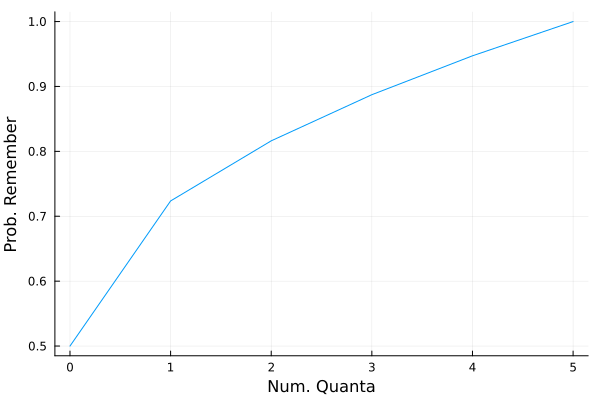

In [8]:


# then what's the relationship between number of quanta and successfully remembering?
function prob_remember(num_quanta)
    dv = 2*(-2.5 .+ num_quanta)
    return 1 ./ (1 .+exp.(-dv))
end

function prob_remember(num_quanta)
    return .5 .+ ((.2*num_quanta).^.5)/2
end


function get_state_reward(s, object_probe_probs, per_timestep_probe_prob)

    return prob_remember(s)'*object_probe_probs*per_timestep_probe_prob

end

x = 0:5

plot(x,prob_remember(x), legend=false)
xlabel!("Num. Quanta")
ylabel!("Prob. Remember")

In [53]:

function get_s_prime_given_action_and_degraded_object(s,A_object,degraded_object)
    
    s_prime = copy(s)
    s_prime[degraded_object]-=1
    s_prime[A_object]+=1
   
    return s_prime
    
end

function get_possible_s_prime_and_probs(s,A) # add N_Objects to this?
    
    N_Objects = length(s)
    
    # possible next states
    possible_S_prime = [get_s_prime_given_action_and_degraded_object(s,A,i) for i in 1:N_Objects]

    # probability that object is selected for degradation...
    prob_S_prime = [s[i]/N_Quanta for i in 1:N_Objects]
    
    possible_S_prime = possible_S_prime[prob_S_prime .> 0]
    prob_S_prime = prob_S_prime[prob_S_prime .> 0]
    
    return possible_S_prime, prob_S_prime
end


# then, from there, you get the next rewards and next values, etc...

get_possible_s_prime_and_probs (generic function with 1 method)

In [54]:

function generate_all_states(N_Quanta, N_Objects)
    all_states = []

    for x in Iterators.product(Iterators.repeated(0:N_Quanta, N_Objects)...)
        if sum(x) == N_Quanta
            push!(all_states, x)
        end
    end
    return all_states
end

S = generate_all_states(N_Quanta,N_Objects)

NS = length(S)

function get_state_index(this_state,S)
    return findfirst(isequal(this_state), S)

end

get_state_index((1,1, 0,8) , S)

In [55]:
# one loop of value iteration...

function get_optimal_V(S,object_probe_probs, per_timestep_probe_prob)
    
    
    NS = length(S)
    
    max_change = 1e3
    gamma = .99

    # initialize V
    V = zeros(NS)

    while max_change > 1e-9


        V_new = copy(V)

        # loop through each state
        for s_idx in 1:NS

            s = S[s_idx]

            legal_actions = findall(s.>0)

            N_legal_actions = length(legal_actions)

            # compute Q value for each action and take max
            Q = zeros(N_legal_actions)
            for a_idx in 1:N_legal_actions

                A = legal_actions[a_idx]

                possible_S_prime, prob_S_prime = get_possible_s_prime_and_probs(collect(s),A)

                possible_R_s = [get_state_reward(this_s, object_probe_probs, per_timestep_probe_prob) for this_s in possible_S_prime]

                possible_S_prime_idxs = [get_state_index(tuple(this_s...),S) for this_s in possible_S_prime]

                possible_V_s_prime = V[possible_S_prime_idxs]

                Q[a_idx] = prob_S_prime'*(possible_R_s + gamma*possible_V_s_prime)
            end

            V_new[s_idx] = maximum(Q)

        end

        max_change = maximum(abs.(V_new - V))
        V = V_new

    end
    
    return V
    
end

get_optimal_V (generic function with 1 method)

In [56]:
V = get_optimal_V(S,object_probe_probs, per_timestep_probe_prob)

21-element Vector{Float64}:
 9.933071392575458
 9.91740484555497
 9.875021669085344
 9.801960334482578
 9.707751141024357
 0.06692850858130572
 9.91740484555497
 9.875021669085344
 9.80196033448258
 9.707751141024358
 0.06692850858130572
 9.875021669085344
 9.801960334482578
 9.70775114102436
 0.06692850858130572
 9.801960334482578
 9.707751141024358
 0.06692850858130572
 9.707751141024357
 0.06692850858130572
 0.06692850858130572

In [57]:
per_timestep_probe_prob

0.1

In [60]:
function get_optimal_policy(S,object_probe_probs, per_timestep_probe_prob)

    NS = length(S)
    policy = zeros(NS)
    for s_idx in 1:NS

        # loop through each state

        s = S[s_idx]

        legal_actions = findall(s.>0)

        N_legal_actions = length(legal_actions)

        # compute Q value for each action and take max
        Q = zeros(N_legal_actions)
        for a_idx in 1:N_legal_actions

            A = legal_actions[a_idx]

            possible_S_prime, prob_S_prime = get_possible_s_prime_and_probs(collect(s),A)

            possible_R_s = [get_state_reward(this_s, object_probe_probs, per_timestep_probe_prob) for this_s in possible_S_prime]

            possible_S_prime_idxs = [get_state_index(tuple(this_s...),S) for this_s in possible_S_prime]

            possible_V_s_prime = V[possible_S_prime_idxs]

            Q[a_idx] = prob_S_prime'*(possible_R_s + gamma*possible_V_s_prime)
        end

        policy[s_idx] = legal_actions[argmax(Q)]

    end
   
    return policy
    
end

policy = get_optimal_policy(S,object_probe_probs, per_timestep_probe_prob)

21-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 2.0
 1.0
 1.0
 1.0
 1.0
 2.0
 1.0
 1.0
 1.0
 2.0
 1.0
 1.0
 2.0
 1.0
 2.0
 3.0

In [61]:
[print(S[i], policy[i], "\n")  for i in 1:NS]

(5, 0, 0)1.0
(4, 1, 0)1.0
(3, 2, 0)1.0
(2, 3, 0)1.0
(1, 4, 0)1.0
(0, 5, 0)2.0
(4, 0, 1)1.0
(3, 1, 1)1.0
(2, 2, 1)1.0
(1, 3, 1)1.0
(0, 4, 1)2.0
(3, 0, 2)1.0
(2, 1, 2)1.0
(1, 2, 2)1.0
(0, 3, 2)2.0
(2, 0, 3)1.0
(1, 1, 3)1.0
(0, 2, 3)2.0
(1, 0, 4)1.0
(0, 1, 4)2.0
(0, 0, 5)3.0


21-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing